# 5 Nonlinear Regression Models

# 5.1 Neural networks

In [1]:
#use the boston housing data
#build a neural net model to predict "medv" using 
library(MASS)
library(neuralnet)
library(tidyverse)
library(caret)

#method = nnet
library(nnet)


Warning message:
"package 'ggplot2' was built under R version 4.2.3"
Warning message:
"package 'dplyr' was built under R version 4.2.3"
-- Attaching core tidyverse packages ------------------------ tidyverse 2.0.0 --
v dplyr     1.1.4     v readr     2.1.4
v forcats   1.0.0     v stringr   1.5.0
v ggplot2   3.5.1     v tibble    3.2.1
v lubridate 1.9.2     v tidyr     1.3.0
v purrr     1.0.1     
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::compute() masks neuralnet::compute()
x dplyr::filter()  masks stats::filter()
x dplyr::lag()     masks stats::lag()
x dplyr::select()  masks MASS::select()
i Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift




# min-max normalization (scaling)

In [2]:
# there are 14 variables : medv is the price of house (response)
data(Boston)
str(Boston)

set.seed(252)

#Data preprocessing 
#scaling - way1
#min-max normalization
#min-max normalization

scale.fun = function(x) {
    (x - min(x)) / (max(x) - min(x))
}

miny=min(Boston$medv)
range.y=max(Boston$medv)-miny

#Trnasform the data
Boston.dat = Boston %>% mutate_all(scale.fun)

#split the data
#split the data into training and testing set according to medv

index = createDataPartition((Boston.dat$medv), p = 0.8, list = FALSE)
train.dat= Boston.dat[index, ]
test.dat = Boston.dat[-index, ]



'data.frame':	506 obs. of  14 variables:
 $ crim   : num  0.00632 0.02731 0.02729 0.03237 0.06905 ...
 $ zn     : num  18 0 0 0 0 0 12.5 12.5 12.5 12.5 ...
 $ indus  : num  2.31 7.07 7.07 2.18 2.18 2.18 7.87 7.87 7.87 7.87 ...
 $ chas   : int  0 0 0 0 0 0 0 0 0 0 ...
 $ nox    : num  0.538 0.469 0.469 0.458 0.458 0.458 0.524 0.524 0.524 0.524 ...
 $ rm     : num  6.58 6.42 7.18 7 7.15 ...
 $ age    : num  65.2 78.9 61.1 45.8 54.2 58.7 66.6 96.1 100 85.9 ...
 $ dis    : num  4.09 4.97 4.97 6.06 6.06 ...
 $ rad    : int  1 2 2 3 3 3 5 5 5 5 ...
 $ tax    : num  296 242 242 222 222 222 311 311 311 311 ...
 $ ptratio: num  15.3 17.8 17.8 18.7 18.7 18.7 15.2 15.2 15.2 15.2 ...
 $ black  : num  397 397 393 395 397 ...
 $ lstat  : num  4.98 9.14 4.03 2.94 5.33 ...
 $ medv   : num  24 21.6 34.7 33.4 36.2 28.7 22.9 27.1 16.5 18.9 ...


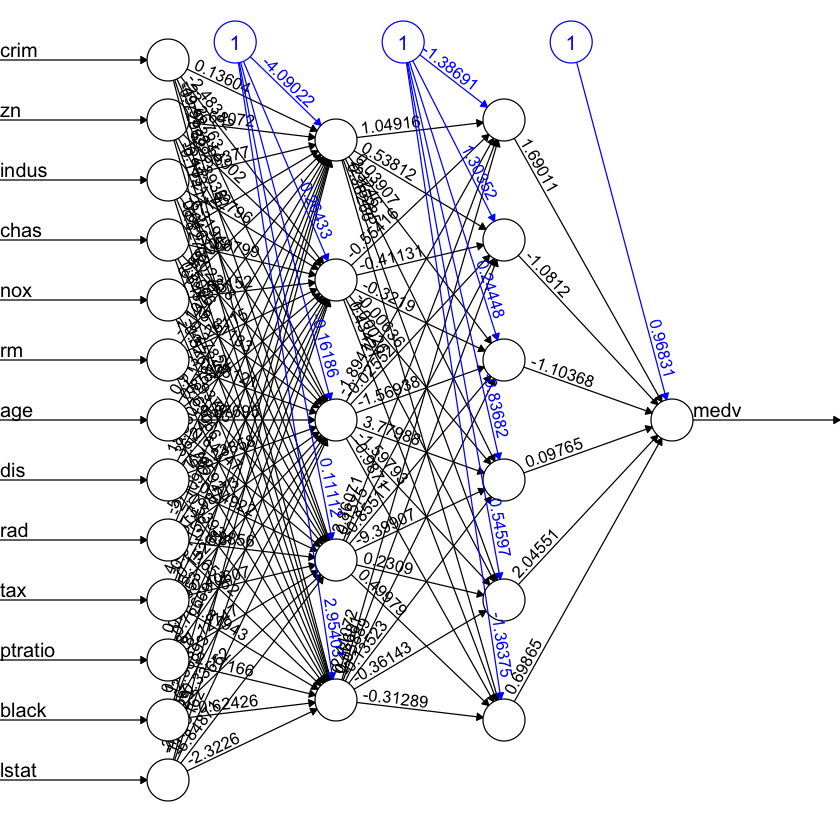

In [3]:
#build a neural network
# hidden = c(5,6) : two hidden layers, 
# 6 neurons in the first hidden layer 
# and 4 neurons in the second hidden layer

nn.fit = neuralnet(medv ~ ., data = train.dat, hidden = c(5,6), linear.output = TRUE)
plot(nn.fit, rep ="best")
# The number of weights : a lot 13 * 5*6=390



[1] 2.800642

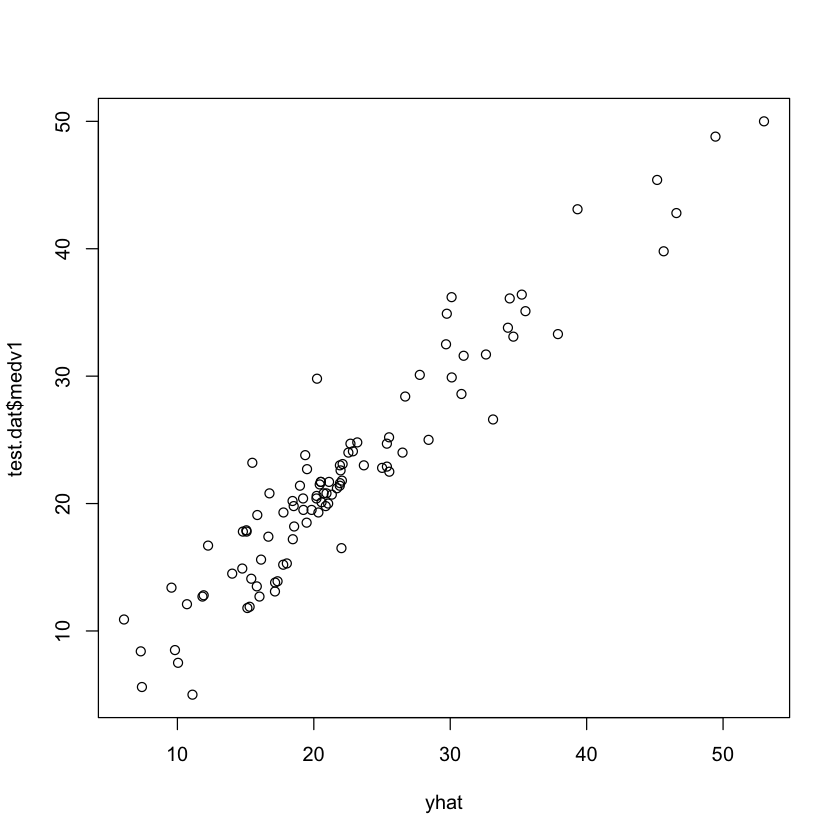

In [4]:
# make prediction on the test set 

# to make prediction using the data set

yhat.0 = predict(nn.fit, test.dat)

#miny=min(Boston$medv)zr
#range.y=max(Boston$medv)-miny

#transform the results back to the original scale
yhat= yhat.0 * range.y + miny
test.dat$medv1 = test.dat$medv * range.y + miny

#MSE on the testing data
plot(yhat,test.dat$medv1)

#RMSE on the testing data
sqrt(mean((yhat - test.dat$medv1)^2))

# weights:  76
initial  value 39.741886 
iter  10 value 10.029028
iter  20 value 9.283633
iter  30 value 9.263421
iter  40 value 9.215527
iter  50 value 9.192364
iter  60 value 9.183080
iter  70 value 9.182365
iter  80 value 9.182144
final  value 9.182142 
converged


[1] 4.407407

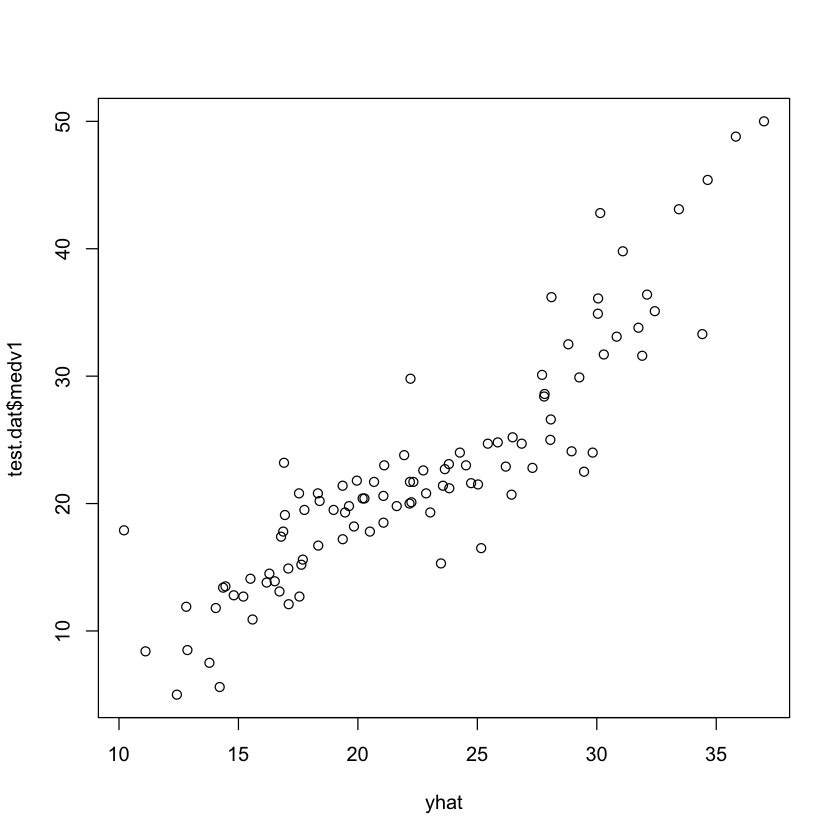

In [5]:
# please use nnet to build a neural network model to predict "medv" 
#using all other features
#the hyperparameters are size=5 and decay=0.2

fit2= nnet(medv ~., data=train.dat, size=5, decay=0.2)

#make prediction on the test set

#to make prediction using the testing data
yhat.2 = predict(fit2, test.dat)


#transform the results back to the original scale
yhat = yhat.2*range.y + miny

#MSE on the testing data
plot(yhat, test.dat$medv1)

#RMSE on the testing data
sqrt(mean((yhat - test.dat$medv1)^2))

In [6]:
# Model training using the caret package : train function
set.seed (295)
#Cross validation : 7 fold cross validaiton
ctrl = trainControl (method = "cv", number = 7)

#two hyper-parameters: size and decay
#Size is the number of units in hidden layer (nnet fit a single hidden Layer
# decay is the regularization parameter to avoid over-fitting
#nnet.Grid = expand.grid (size = c(3, 4, 5), decay = c(0.01, .1))

nnet.Grid <- expand.grid(size = seq(from = 6, to = 15, by = 1), 
                         decay = seq(from = 0, to = 0.1, by = 0.05))

#nnet.Grid <- expand.grid(size = seq(from = 6, to = 15, by = 1), 
                         #decay = seq(from = 0.01, to = 0.1, by = 0.01))

n.fit <- train(medv ~ ., data = train.dat, method = "nnet",
               trControl = ctrl,
               linout = TRUE,
               trace = FALSE,
               tuneGrid = nnet.Grid,
               preProc = c("center", "scale"),
               maxit = 500)

#The best tuning pamerters are: 6 netrons and weight decay rate is 0.1
# the best tuning parameters
n.fit$bestTune


,size,decay
,<dbl>,<dbl>
17,11,0.05


In [7]:
n.fit$bestTune

,size,decay
,<dbl>,<dbl>
17,11,0.05


[1] 2.903464

[1] 2.173226

[1] 2.903464

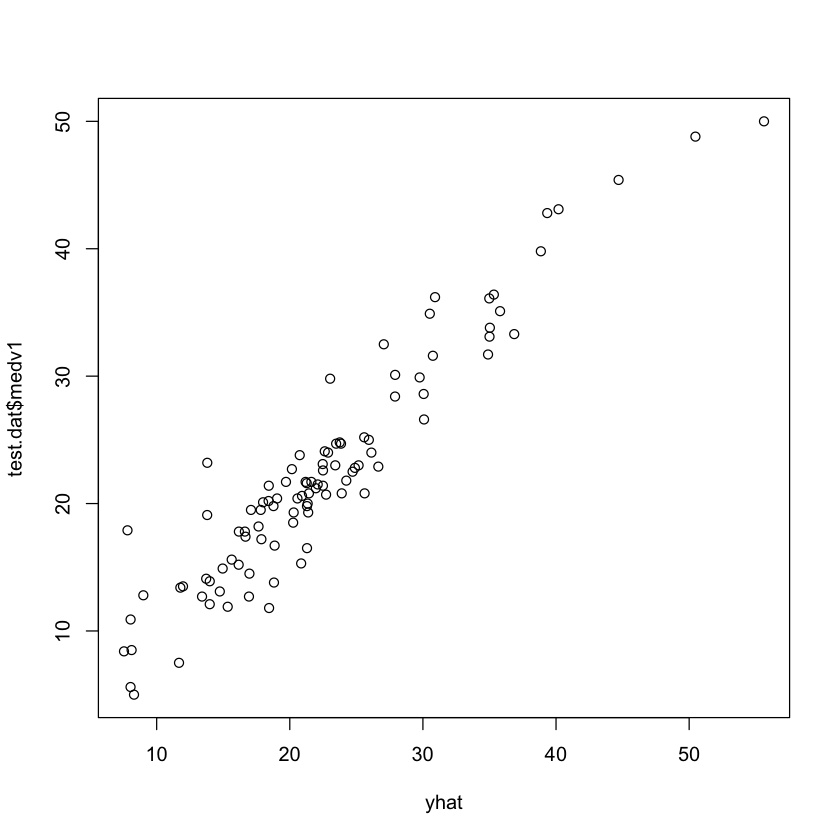

In [50]:
# To make prediction on the test set
yhat.3 = predict(n.fit, test.dat)

#transform the results back to the original scale
yhat = yhat.3 * range.y + miny

#RMSE on the testing data
sqrt(mean((yhat - test.dat$medv1)^2))

#MAE on the testing data of the fitted model 
caret::MAE(test.dat$medv1, yhat)

#RMSE on the testing data of the fitted model
caret::RMSE(test.dat$medv1, yhat)

#plot the predicted value against the observed value
plot(yhat, test.dat$medv1)


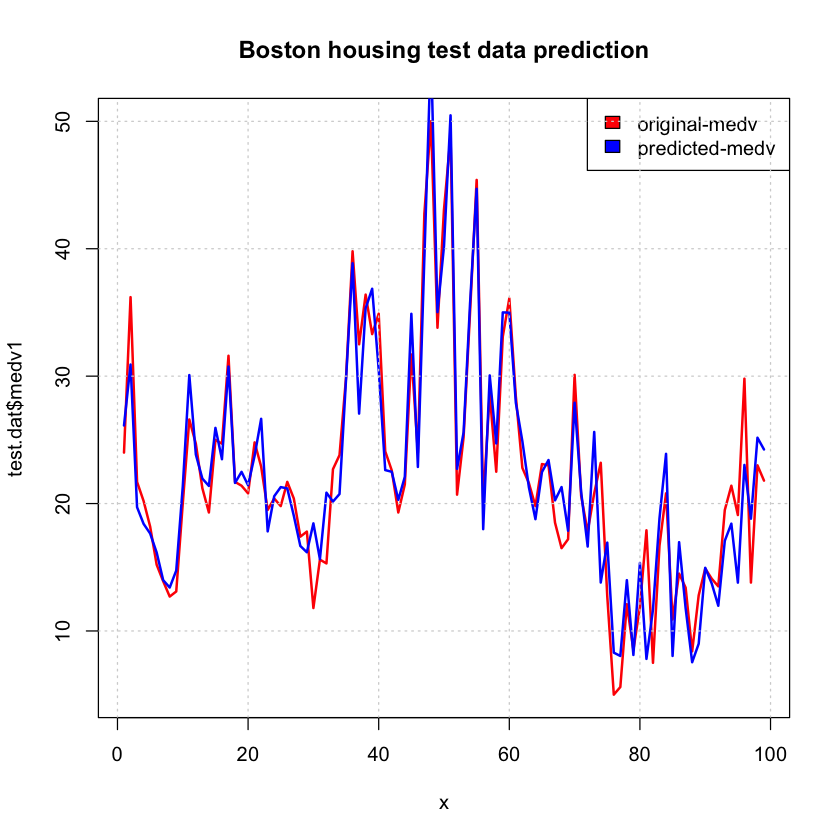

In [9]:
# line plots to see the performance
# predicted value vs observed values

x = 1:length(yhat)
plot(x, test.dat$medv1,col="red",type = "l",lwd=2, 
    main = "Boston housing test data prediction")
lines(x,yhat,col="blue",lwd=2)
legend("topright",legend=c("original-medv","predicted-medv"),
        fill = c("red","blue"),col=2:3, adj=c(0,0.6))
grid()


# Ensemble models

In [10]:
library(caret)
library(nnet)

In [14]:
#train function 

set.seed(295)
ctrl = trainControl(method="cv", number=10)

#when you train a neural network (nnet) using caret
#two hyper-parameters : size and decay

#size is the number of units in hidden layer (nnet fit a single hidden layer neural network)
#decay is the regularization parameter to avoid over-fitting

nnet.Grid = expand.grid(decay=c(0,0.01,0.05,.1),size=1:6,bag=FALSE)
#24 combinations
#Or

#nnet.grid <- epand.grid(size=1:8, decay=seq(from =0.1, to=0.5, by=0.1), bag=FALSE)
#averaged neural network
#a type of neural network ensemble method that combines multiple neural networks to improve performance
#"ensemble" used to improve the generalization and robustness of predictions
#to reduce overfitting and improve prediction accuracy


avnet.fit = train(medv~., data=train.dat, 
                   method="avNNet", 
                   tuneGrid=nnet.Grid,
                   trControl=ctrl, 
                   preProc=c("center","scale"),
                   linout=TRUE,
                   trace=FALSE,
                   maxit=100,
                   allowParallel=FALSE)

#yhat0 = predict(nnet.fit, test.dat)

#transform back to the original scale
#yhat = yhat0 * range.y + miny
#plot(test.dat$medv1,yhat0, xLab="Observed", yLab="Predicted", main="Boston Housing Data")


In [47]:
#summary(avnet.fit)
#avnet.fit

#Make prediction on the testing data
yhat.avnet = predict(avnet.fit,test.dat)

#transform back to the original scale
yhat0 = yhat.avnet * range.y + miny

#transform back to the original scale
test.dat$medv1 = test.dat$medv * range.y + miny

#RMSE
#sqrt(mean((yhat0-test.dat$medv1)^2))

#MAE on the testing data of the fitted model
caret :: MAE(test.dat$medv1, yhat0)

#RMSE on the testing data of the fitted model
caret :: RMSE(test.dat$medv1, yhat0)

[1] 2.073131

[1] 2.696184

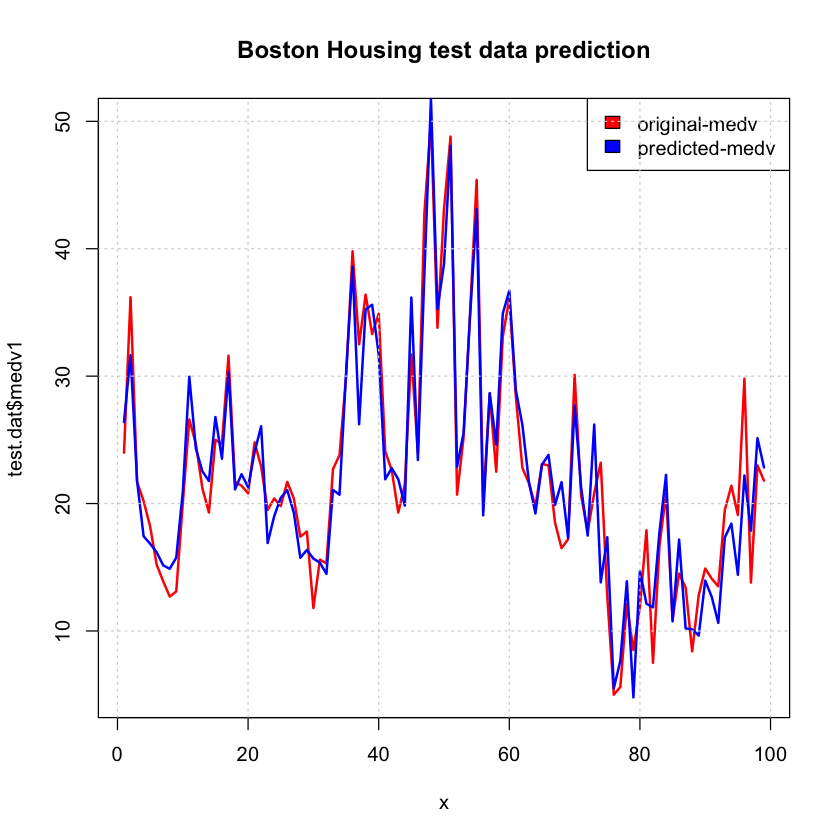

In [48]:
#line plots to see the performance
#predicted value vs observed values
plot(x,test.dat$medv1,col="red",type="l",lwd=2,
     main="Boston Housing test data prediction")
lines(x,yhat0,col="blue",lwd=2)
legend("topright",legend=c("original-medv","predicted-medv"),
        fill=c("red","blue"),col=2:3,adj=c(0,0.6))
grid()